# Associations between microbial presence/absence and patient info

In [1]:
setwd("/mnt/c/Users/Cedric/Desktop/git_repos/blood_microbiome")
require(tidyverse)
require(ggplot2)
require(data.table)
require(foreach)
require(RColorBrewer)
require(ggpubr)

Loading required package: tidyverse

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: data.table


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


Loading required package: foreach


Attaching package: ‘foreach’


The following objects are masked from ‘package:purrr’:

    accumulate, when


Loading required packag

### Load  data

In [2]:
X <- fread("results/decontamination/prevalence_RA0.005_read10.csv")
nc <- fread("results/decontamination/curated_n122_global_decontamination_stats.csv")
nc_filt <- nc %>%
    filter(site != "")
X <- X %>% select(all_of(c("npm_research_id", unique(nc$taxa))))
X2 <- X %>% select(all_of(c("npm_research_id", unique(nc_filt$taxa))))
RA_df <- fread("results/decontamination/RA_matrix_n122.global_decontaminated.zeroed.csv")

meta <- fread("data/20210125_v3_release/20210203_all_traits_v3.txt")
meta2 <- fread("data/SG10K_Health_metadata.n10714.16March2021.parsed.csv")

n <- gsub("[^0-9A-Za-z///' ]", " ", colnames(meta))
n <- tolower(n)
n <- gsub(" ", "_", n)
colnames(meta) <- n

fwrite(meta, "data/20210125_v3_release/20210203_all_traits_v3.parsed.csv")

### Group sites

In [3]:
site_list <- unique(nc$site)
site_list <- site_list[site_list != ""]
site_list

[1] "gut"               "oral"              "genitals"         
[4] "skin"              "blood"             "respiratory tract"
[7] "eye"

In [4]:
site_morsels <- foreach(site_name = site_list) %do% {
    taxa_list <- (nc %>% filter(site == site_name))$taxa
    X_site_temp <- X %>%
        column_to_rownames("npm_research_id") %>%
        select(all_of(taxa_list)) %>%
        mutate(combined = rowSums(.), .before = 1)  %>%
        mutate(combined = ifelse(combined > 0, 1, 0)) %>%
        select(combined)

    colnames(X_site_temp) <- site_name
    X_site_temp
}

site_morsels2 <- foreach(site_name = site_list) %do% {
    taxa_list <- (nc %>% filter(site == site_name))$taxa
    X_site_temp <- X2 %>%
        column_to_rownames("npm_research_id") %>%
        select(all_of(taxa_list)) %>%
        mutate(combined = rowSums(.), .before = 1)  %>%
        mutate(combined = ifelse(combined > 0, 1, 0)) %>%
        select(combined)

    colnames(X_site_temp) <- site_name
    X_site_temp
}

X_meta <- bind_cols(site_morsels) %>%
    rownames_to_column("npm_research_id") %>%
    left_join(meta, "npm_research_id") %>%
    left_join(meta2, "npm_research_id") %>%
    as_tibble()

X2_meta <- bind_cols(site_morsels2) %>%
    rownames_to_column("npm_research_id") %>%
    left_join(meta, "npm_research_id") %>%
    left_join(meta2, "npm_research_id") %>%
    as_tibble()

### Add microbial presence column

In [5]:
row_sums <- X %>% 
    column_to_rownames("npm_research_id") %>%
    rowSums()

presence_df <- tibble(npm_research_id = names(row_sums), n_present = row_sums) %>%
    mutate(presence = ifelse(n_present > 0, 1, 0))

X_meta <- X_meta %>%
    left_join(presence_df, "npm_research_id")


row_sums2 <- X2 %>% 
    column_to_rownames("npm_research_id") %>%
    rowSums()

presence_df2 <- tibble(npm_research_id = names(row_sums2), n_present = row_sums2) %>%
    mutate(presence = ifelse(n_present > 0, 1, 0))

X2_meta <- X2_meta %>%
    left_join(presence_df2, "npm_research_id")

### Add unhealthy parameters

HBP: https://www.cdc.gov/bloodpressure/about.htm
Tg: https://www.healthxchange.sg/heart-lungs/heart-disease/how-triglycerides-affect-your-heart#:~:text=Borderline%20high%20%E2%80%94%20150%20to%20199,5.7%20mmol%2FL%20or%20above)
Age: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4282767/#B12

In [6]:
median(X_meta$tc_mmol_l, na.rm = T)

[1] 5.23

`summarise()` has grouped output by 'condition'. You can override using the `.groups` argument.


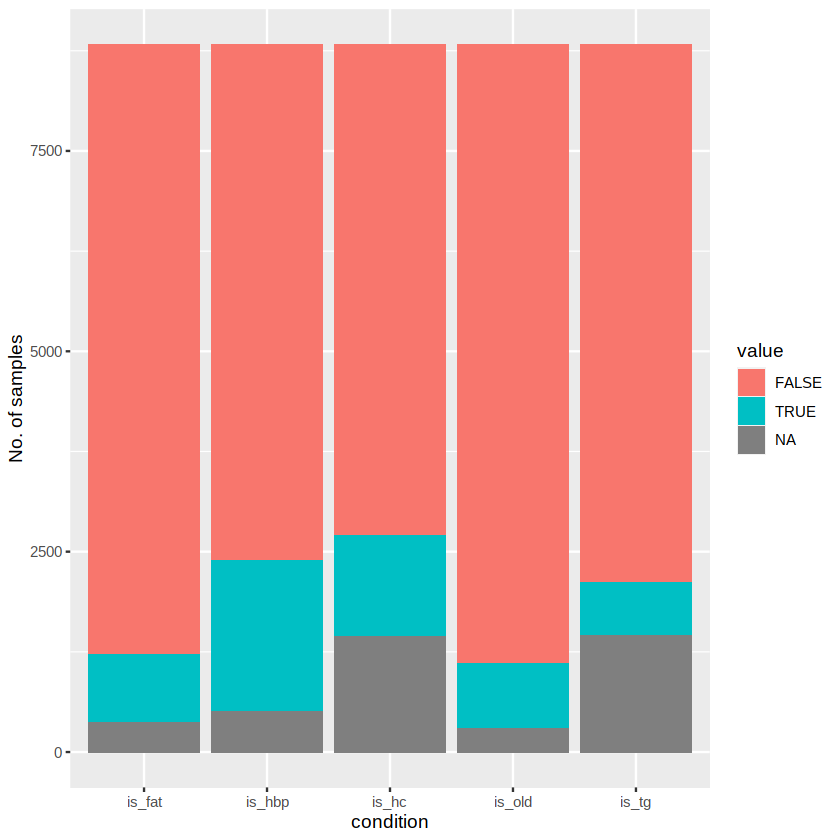

In [7]:
X_parsed <- X_meta %>%
    mutate(is_fat = case_when(is.na(bmi) ~ NA,
                              bmi > 30 ~ T,
                              bmi <= 30 ~ F),
           is_tg = case_when(is.na(tg_mmol_l) ~ NA,
                          tg_mmol_l > 2.3 ~ T,
                          tg_mmol_l <= 2.3 ~ F), 
           is_old = case_when(is.na(age) ~ NA,
                              age >= 65 ~ T,
                              age < 65 ~ F),
           is_hbp = case_when(is.na(sbp) | is.na(dbp) ~ NA,
                              sbp >= 130 & dbp >= 80 ~ T,
                              TRUE ~ F),
           is_hc = case_when(is.na(tc_mmol_l) ~ NA,
                             tc_mmol_l >= 6.2 ~ T,
                             tc_mmol_l < 6.2 ~ F))

X_parsed %>%
    select(is_fat, is_tg, is_old, is_hbp, is_hc) %>%
    pivot_longer(everything(), names_to = "condition", values_to = "value") %>%
    group_by(condition, value) %>%
    summarise(n = n()) %>%
    ggplot(aes(x = condition, y = n, fill = value)) +
    geom_bar(stat = "identity") +
    labs(x = "condition", y = "No. of samples")

In [8]:
var_list <- c("is_fat", "is_old", "is_hbp", "is_tg", "is_hc")

In [9]:
remove_cohorts <- function(X_parsed, var_name) {
    # Remove cohorts with low numbers of phenotype
    to_remove <- X_parsed %>% 
        group_by_at(c(var_name, "site_supplying_sample")) %>%
        summarise(prevalence = sum(presence) / n(), n_pos = sum(presence), n_total = n()) %>%
        filter(n_total < 30,
               !is.na(get(var_name)))

    to_remove <- c(to_remove$site_supplying_sample, "GUSTO", "SSMP")

    X_filt <- X_parsed %>%
        mutate(site_supplying_sample = factor(site_supplying_sample)) %>%
        filter(!is.na(get(var_name)),
               !(site_supplying_sample %in% to_remove))
    return(X_filt)
}

### Fisher's exact test

In [10]:
fisher_morsels <- foreach(var_name = var_list) %do% {
    # Remove cohorts with low numbers of phenotype
    X_filt <- remove_cohorts(X_parsed, var_name)
    cohort_list <- unique(X_filt$site_supplying_sample)
    
    foreach(cohort_name = cohort_list) %do% {
        X_filt2 <- X_filt %>% filter(site_supplying_sample == cohort_name)
        
        obs_test <- fisher.test(X_filt2$presence, deframe(X_filt2[var_name]))
        obs_OR <- obs_test$estimate
        obs_pval <- obs_test$p.value
        n_true <- sum(X_filt2[var_name], na.rm = T)
        n_false <- sum(!X_filt2[var_name], na.rm = T)
        return(tibble(cohort = cohort_name, 
                      variable = var_name, 
                      OR = obs_OR, 
                      p.val = obs_pval,
                      phenotype_breakdown = str_glue("{n_true}T/{n_false}F")))
    }
}

fisher_results <- bind_rows(fisher_morsels)


`summarise()` has grouped output by 'is_fat'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'is_old'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'is_hbp'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'is_tg'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'is_hc'. You can override using the `.groups` argument.


In [13]:
final_results <- fisher_results %>%
    mutate(p.adj = p.adjust(p.val, method = "BH"))
fwrite(final_results, "results/phenotype_associations/derived_phenotype_associations.csv")

In [12]:
dawddwadw

ERROR: Error in eval(expr, envir, enclos): object 'dawddwadw' not found


### Permutation test

In [ ]:
morsels <- foreach(var_name = var_list) %do% {
    # Remove cohorts with low numbers of phenotype
    X_filt <- remove_cohorts(X_parsed, var_name)
    cohort_list <- unique(X_filt$site_supplying_sample)
    
    # Plot
    plt1 <- X_filt %>%
        group_by_at(c(var_name, "site_supplying_sample")) %>%
        summarise(prevalence = sum(presence) / n(), n_pos = sum(presence), n_total = n()) %>%
        ggplot(aes(x = get(var_name), y = prevalence, fill = site_supplying_sample)) +
        geom_bar(stat = "identity") +
        facet_grid(rows = vars(site_supplying_sample)) +
        geom_text(aes(y = prevalence, label = n_pos),
                  vjust = 0,
                  color = "red") +
        geom_text(aes(y = -0.1, label = paste0("n_sampled = ", n_total)),
                  vjust = 0,
                  color = "black") +
        ylim(-0.1, 0.4) +
        labs(x = var_name, y = "Prevalence") +
        theme(legend.position = "none")

    plt2 <- X_filt %>%
        group_by_at(c(var_name)) %>%
        summarise(prevalence = sum(presence) / n(), n_pos = sum(presence), n_total = n()) %>%
        ggplot(aes(x = get(var_name), y = prevalence)) +
        geom_bar(stat = "identity") +
        geom_text(aes(y = prevalence, label = n_pos),
                  vjust = 0,
                  color = "red") +
        geom_text(aes(y = -0.01, label = paste0("n_sampled = ", n_total)),
                  vjust = 0,
                  color = "black") +
        labs(x = var_name, y = "Prevalence") 

    combined <- ggarrange(plt2, plt1)
    ggsave(str_glue("results/phenotype_associations/unhealthy/{var_name}.png"), plot = combined, 
           width = 8, height = 5)
    
    foreach(cohort_name = cohort_list) %do% {
        X_filt2 <- X_filt %>% filter(site_supplying_sample == cohort_name)
        
        # Permutation test
        obs_test <- fisher.test(X_filt2$presence, deframe(X_filt2[var_name]))
        obs_OR <- obs_test$estimate
        
        set.seed(66)
        perm_morsels <- foreach(i = seq(1000)) %do% {
            temp <- X_filt2 %>% mutate(presence = sample(presence))
            temp_test <- fisher.test(temp$presence, deframe(temp[var_name]))
            temp_OR <- temp_test$estimate
            tibble(odds_ratio = temp_OR)
        }

        perm_res <- bind_rows(perm_morsels)
        pval <- sum(perm_res$odds_ratio <= obs_OR) / 1000
        n_true <- sum(X_filt2[var_name], na.rm = T)
        n_false <- sum(!X_filt2[var_name], na.rm = T)
        return(tibble(cohort = cohort_name, 
                      variable = var_name, 
                      OR = obs_OR, 
                      p.val = pval,
                      phenotype_breakdown = str_glue("{n_true}T/{n_false}F")))
    }
}

final_results <- bind_rows(morsels)


In [ ]:
final_results %>%
mutate(p.adj = p.adjust(p.val, method = "BH"))

### Correlation between age and other health paramaters

In [ ]:
parameter_list <- c("sbp", "dbp", "tc_mmol_l", "tg_mmol_l", "bmi")
# var_name <- "bmi"

foreach(var_name = parameter_list) %do% {
    x_filt <- X_meta %>%
        filter(!is.na(age) & !is.na(get(var_name)))
    X_filt %>%
        ggplot(aes(x = age, y = log(get(var_name)))) +
        labs(x = "Age", y = var_name) +
        geom_point() +
        geom_smooth() +
        theme_bw()
    
    ggsave(str_glue("results/phenotype_associations/age_associations/age_{var_name}.png"), dpi = 600)
}

In [ ]:
plot_df <- X %>%
    inner_join(X_filt_meta) %>%
    column_to_rownames("npm_research_id") %>%
    pivot_longer(!is_old, names_to = "taxa", values_to = "presence") %>%
    group_by(taxa, is_old) %>%
    summarise(prevalence = sum(presence) / n()) 

taxa_order <- plot_df %>% 
    filter(is_old) %>%
    arrange(desc(prevalence))

plot_df %>%
    mutate(taxa = factor(taxa, taxa_order$taxa)) %>%
    ggplot(aes(x = taxa, y = prevalence, fill = is_old)) +
    geom_bar(stat = "identity", position = "dodge") + 
    theme(axis.text.x = element_text(angle = 45, hjust =  1)) 

ggsave("results/phenotype_associations/unhealthy/is_old.taxa.pdf", width = 15, height = 15)

In [ ]:
level_names <- c("<21", "21-30", "31-40", "41-50", "51-60", "61-70", ">70")
pal <- c(rev(brewer.pal(length(level_names), "RdYlGn")))
pal <- setNames(pal, level_names)
pal

In [ ]:
test <- X_parsed %>% 
    filter(!is.na(age),
           site_supplying_sample != "GUSTO") %>%
#     select(age, presence) %>%
    mutate(age_bin = case_when(age <= 20 ~ "<21",
                               age > 20 & age <= 30 ~ "21-30",
                               age > 30 & age <= 40 ~ "31-40",
                               age > 40 & age <= 50 ~ "41-50",
                               age > 50 & age <= 60 ~ "51-60",
                               age > 60 & age <= 70 ~ "61-70",
                               age > 70 ~ ">70")) %>%
    mutate(age_bin = factor(age_bin, c("<21", "21-30", "31-40", "41-50", "51-60", "61-70", ">70")))

test %>%
    group_by(age_bin) %>%
    summarise(prevalence = sum(presence) / n(), n_sampled = n()) %>%
    filter(n_sampled > 50) %>%
    ggplot(aes(x = age_bin, y = prevalence, fill = age_bin)) +
        geom_bar(stat = "identity") +
        labs(x = "Age group", y = "Prop. of microbe-positive samples") +
        geom_text(aes(y = -0.01, label = paste0("n = ", n_sampled))) +
        scale_x_discrete(drop = FALSE) +
        scale_fill_manual(values = pal) +
        theme(legend.position = "none")

ggsave("results/phenotype_associations/unhealthy/all_samples.png")

In [ ]:
cohort_list <- unique(X2_meta$site_supplying_sample)
cohort_list <- cohort_list[cohort_list != "GUSTO"]
cohort_list <- cohort_list[cohort_list != "SSMP"]
cohort_list

age_plts <- foreach(cohort_name = cohort_list) %do%{
    test <- X2_meta %>% 
        filter(!is.na(age),
               site_supplying_sample == cohort_name)

    age_plt1 <- test %>%
        select(age, presence) %>%
        mutate(age_bin = case_when(age <= 20 ~ "<21",
                                   age > 20 & age <= 30 ~ "21-30",
                                   age > 30 & age <= 40 ~ "31-40",
                                   age > 40 & age <= 50 ~ "41-50",
                                   age > 50 & age <= 60 ~ "51-60",
                                   age > 60 & age <= 70 ~ "61-70",
                                   age > 70 ~ ">70")) %>%
        mutate(age_bin = factor(age_bin, c("<21", "21-30", "31-40", "41-50", "51-60", "61-70", ">70"))) %>%
        group_by(age_bin) %>%
        summarise(prevalence = sum(presence) / n(), n_sampled = n()) %>%
        filter(n_sampled > 50) %>%
        ggplot(aes(x = age_bin, y = prevalence, fill = age_bin)) +
            geom_bar(stat = "identity") +
            labs(x = "Age", y = "Prevalence", title = cohort_name) +
            geom_text(aes(y = -0.01, label = paste0("n = ", n_sampled))) +
            scale_x_discrete(drop = FALSE) +
            scale_fill_manual(values = pal) +
            theme(legend.position = "none")
}

ggarrange(plotlist = age_plts, nrow = 5)

# ggsave("results/phenotype_associations/unhealthy/age_distribution.png", width = 6, height = 12)


In [ ]:
cohort_list <- unique(X_meta$site_supplying_sample)
cohort_list <- cohort_list[cohort_list != "GUSTO"]
cohort_list <- cohort_list[cohort_list != "SSMP"]
cohort_list

age_plts <- foreach(cohort_name = cohort_list) %do%{
    test <- X_parsed %>% 
        filter(!is.na(age),
               site_supplying_sample == cohort_name)

    age_plt1 <- test %>%
        select(age, presence) %>%
        mutate(age_bin = case_when(age <= 20 ~ "<21",
                                   age > 20 & age <= 30 ~ "21-30",
                                   age > 30 & age <= 40 ~ "31-40",
                                   age > 40 & age <= 50 ~ "41-50",
                                   age > 50 & age <= 60 ~ "51-60",
                                   age > 60 & age <= 70 ~ "61-70",
                                   age > 70 ~ ">70")) %>%
        mutate(age_bin = factor(age_bin, c("<21", "21-30", "31-40", "41-50", "51-60", "61-70", ">70"))) %>%
        group_by(age_bin) %>%
        summarise(prevalence = sum(presence) / n(), n_sampled = n()) %>%
        filter(n_sampled > 50) %>%
        ggplot(aes(x = age_bin, y = prevalence, fill = age_bin)) +
            geom_bar(stat = "identity") +
            labs(x = "Age", y = "Prevalence", title = cohort_name) +
            geom_text(aes(y = -0.01, label = paste0("n = ", n_sampled))) +
            scale_x_discrete(drop = FALSE) +
            scale_fill_manual(values = pal) +
            theme(legend.position = "none")


#     age_plt2 <- test %>%
#         select(age, presence) %>%
#         mutate(age_bin = case_when(age <= 20 ~ "<21",
#                                    age > 20 & age <= 25 ~ "21-25",
#                                    age > 25 & age <= 30 ~ "26-30",
#                                    age > 30 & age <= 35 ~ "31-35",
#                                    age > 35 & age <= 40 ~ "36-40",
#                                    age > 40 & age <= 45 ~ "41-45",
#                                    age > 45 & age <= 50 ~ "46-50",
#                                    age > 50 & age <= 55 ~ "51-55",
#                                    age > 55 & age <= 60 ~ "56-60",
#                                    age > 60 & age <= 65 ~ "61-65",
#                                    age > 65 & age <= 70 ~ "66-70",
#                                    age > 70 ~ ">70")) %>%
#         mutate(age_bin = factor(age_bin, c("<21", "21-25", "26-30", "31-35", 
#                                            "36-40", "41-45", "46-50", "51-55", 
#                                            "56-60", "61-65", "66-70", ">70"))) %>%
#         group_by(age_bin) %>%
#         summarise(prevalence = sum(presence) / n(), n_sampled = n()) %>%
#         filter(n_sampled > 50) %>%
#         ggplot(aes(x = age_bin, y = prevalence, fill = age_bin)) +
#             geom_bar(stat = "identity") +
#             labs(x = "Age", y = "Prevalence of microbes", title = cohort_name) +
#             geom_text(aes(y = -0.01, label = paste0("n = ", n_sampled))) +
#             scale_x_discrete(drop = FALSE) +
#             scale_fill_manual(values = pal)

#     ggarrange(age_plt1, age_plt2, nrow = 2)
}

ggarrange(plotlist = age_plts, nrow = 5)

ggsave("results/phenotype_associations/unhealthy/age_distribution.png", width = 6, height = 12)


In [ ]:
test$ldl_cal_mmol_l

In [ ]:
test %>%
    select(age_bin, tg_mmol_l, glu_fast_mmol_l, sbp, dbp, ldl_cal_mmol_l) %>%
    pivot_longer(!age_bin, names_to = "variable", values_to = "value") %>%
#     group_by(age_bin, variable) %>%
#     summarise(median = median(value, na.rm = T)) %>%
#     arrange(variable)
    ggplot(aes(x = age_bin, y = value)) +
    facet_grid(rows = vars(variable), scales = "free") +
    geom_boxplot()

In [ ]:
var_name <- "is_old"
X_filt <- remove_cohorts(X_parsed, var_name)
# X_filt_meta <- X_filt %>%
#     select(npm_research_id, age)
X_filt

In [ ]:
# Remove cohorts with low numbers of phenotype
var_name <- "is_old"
X_filt <- remove_cohorts(X_parsed, var_name)
X_filt_meta <- X_filt %>%
    select(npm_research_id, age)

RA_df %>%
    inner_join(X_filt_meta) %>%
    column_to_rownames("npm_research_id") %>%
    pivot_longer(!is_old, names_to = "taxa", values_to = "rel_a") %>%
    arrange(desc(rel_a)) %>%
    filter(is_old,
           rel_a > 0.5) %>%
    distinct(taxa)

X %>%
    inner_join(X_filt_meta) %>%
    column_to_rownames("npm_research_id")
#     pivot_longer(!is_old, names_to = "taxa", values_to = "presence") %>%
#     group_by(taxa, is_old) %>%
#     summarise(prevalence = sum(presence) / n()) 
# plot_df

In [ ]:
RA_df %>%
    inner_join(X_filt_meta) %>%
    column_to_rownames("npm_research_id") %>%
    pivot_longer(!is_old, names_to = "taxa", values_to = "rel_a") %>%
    filter(taxa == "Mycolicibacterium aubagnense") %>%
    ggplot(aes(x = rel_a)) +
    geom_density() +
    facet_grid(rows = vars(is_old))

In [ ]:
final_results

In [ ]:
X_parsed